In [834]:
import matplotlib.pyplot as plt
import numpy as nu
import math
from multipletau import autocorrelate
import array
import lmfit
import scipy as sp
import numpy as np
from os import listdir
import sys, os.path
#from iRheology import *

In [835]:
def ReadTable(filename, beadindx = -1, X=0, Y=1, indx=2, skip=1):
    """ Read a table from a text file. It considers a white spaced
        text table with a filled up rectangular data set (no missing
        points in the table).

        Parameters:
        beadindx:   which column to use to factorize?
        X:          index of x coordinate
        Y:          index of y coordinate
        indx:       index of image index column 
                    (proportional to the time)

        skip:       how many lines to skip at the beginning

        Return:
        a poslist list of dicts (see ImageP track results)
        Each dict holds 'X','Y'(if any), 'indx' keys, from which
        'X','Y' are coordinate arrays, 'indx' is the image index (time).
        The position in poslist is the index of the trajectory (bead).
    """
    if os.path.isfile(filename):
        fp = open(filename, 'rt')
    else:
        print("file not found: %s" %filename) 
        return None
    
    a = fp.readlines()
    fp.close()

    #strip the skip part:
    a = a[skip:]
    Ni = len(a)
    #estimate the number of columns from the first row:
    t = (a[0].strip()).split(',')
    Nj = len(t)-1

    #Now read up the table:
    res = []
    for i in range(Ni):
        t = a[i].strip()
        
        l = []
        t = t.split(',')

        for j in range(Nj):
            if t[j+1]=='':
                continue
            l.append(float(t[j+1]))

        res.append(l)
    #end for i
    print("Found: %d lines" %len(res))

    #congvert to poslist:
    res = nu.asarray(res)
    #how many beads? beadindx is the column holding the counter:
    Nb = nu.unique(res[:,beadindx-1])
    print("Max: %d beads" %len(Nb)) 

    poslist = []
    for i in Nb:

        #bindx highlights those lines containing bead i:
        bindx = (res[:,beadindx-1] == i)
        #poslist is a list of dicts
        #each dict holds 'X', 'Y' for position arrays, 
        #and 'indx' for the image indices (may not be continuous)
        poslist.append({"X":res[bindx,X-1], "Y":res[bindx,Y-1],\
                        "indx":res[bindx,indx-1]})

    print("Found: %d beads" %len(poslist))

    return poslist
#end of ReadTable

import numpy as np
import xml.etree.ElementTree as et
 
def loadxmlTrajs(xmlfile):
    """ 
    Load xml files into a python dictionary with the following structure:
        tracks = {'0': {'nSpots': 20, 'trackData': numpy.array(t, x, y, z) }}
    Tracks should be xml file from 'Export tracks to XML file',
    that contains only track info but not the features.
    Similar to what 'importTrackMateTracks.m' needs.
    """
    try:
        tree = et.parse(xmlfile);
    except OSError:
        print('Failed to read XML file {}.'.format(xlmfile) )
    root =  tree.getroot()
    # print(root.attrib)  # or extract metadata
    nTracks = int(root.attrib['nTracks'])
    tracks = {}
    for i in range(nTracks):
        trackIdx = str(i)
        tracks[trackIdx] = {}
        nSpots = int(root[i].attrib['nSpots'])
        tracks[trackIdx]['nSpots'] = nSpots
        trackData = np.array([ ]).reshape(0, 4)
        for j in range(nSpots):
            t = float(root[i][j].attrib['t'])
            x = float(root[i][j].attrib['x'])
            y = float(root[i][j].attrib['y'])
            z = float(root[i][j].attrib['z'])
            spotData = np.array([t, x, y, z])
            trackData = np.vstack((trackData, spotData))
        tracks[trackIdx]['trackData'] = trackData
    return tracks
    # Dump the dictionary with json or pickle it as you want

def get_outlier_bounds(first_values,last_values):

    #find outliers
    sorted_f = np.sort(np.log(first_values))
    
    q1, q3= np.percentile(sorted_f,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr) 

    sorted_l = np.sort(np.log(last_values))
    
    q1, q3= np.percentile(sorted_l,[25,75])
    iqr = q3 - q1
    lower_bound_l = q1 -(1 * iqr) 
    upper_bound_l = q3 +(1.5 * iqr) 
    return lower_bound,upper_bound,lower_bound_l,upper_bound_l

In [1000]:
import os
format_file = '.xml' #.csv or .xml
testdir = r"D:\Anurag_data\Chilkoti's Lab\ELP-amyloid\ELP-amyloid pH 6\Good data\Sample 2\120min_1"
os.listdir(testdir)
os.chdir(testdir)
os.getcwd()
files = listdir()
scans = []
fraps=[]
for file in files:
    if format_file in file  :
        scans.append(file)
index = np.arange(len(scans))
insca = zip(list(index),scans)
list(insca)

[(0, '120min_1_MMStack_Pos0_Tracks.xml')]

In [1001]:
index_to_analyze =0
fname=scans[index_to_analyze]
fname=fname[0:len(fname)-4]
pos= loadxmlTrajs(fname+'.xml')

In [1002]:
pixel_conversion=1
frametime= 0.1 #in seconds
R=0.1 #in microns
T=24 #in Celsius

In [1003]:
sizes = np.zeros((len(pos),))
for i in range(len(pos)): 
    sizes[i]=pos[str(i)]['nSpots']
lastframe=int(max(sizes))
lastframe
minframe = int(min(sizes))

In [1004]:
lastframe, len(pos)

(1000, 17)

In [1005]:
dx_all= np.zeros(int(lastframe-1),)
dy_all = np.zeros(int(lastframe-1),)
count_all = np.zeros(int(lastframe-1),)
counts=[]

for j in range(int(len(pos))):
    Vavg=0
    Xavg=0
    count=0
    dx = np.diff(pos[str(j)]['trackData'][:,1])
    dy = np.diff(pos[str(j)]['trackData'][:,2])
    time=pos[str(j)]['trackData'][:,0]
    start=int(time[0])
    end=start+len(dx)
    dx_all[start:end] = dx_all[start:end] + dx
    dy_all[start:end] = dy_all[start:end] + dy
    count_all[start:end] = count_all[start:end]+1
    dx_avg=dx_all/count_all
    dy_avg=dy_all/count_all
#initial position 
    Xcom0=0
    Ycom0=0
for key in pos:
    Xcom0 += pos[key]['trackData'][0,1]
    Ycom0 += pos[key]['trackData'][0,2]
X0 = Xcom0/len(pos)
Y0=Ycom0/len(pos)

Xcom = [X0 + sum(dx_avg[:i]) for i in range(int(lastframe))]
Ycom = [Y0 + sum(dy_avg[:i]) for i in range(int(lastframe))]

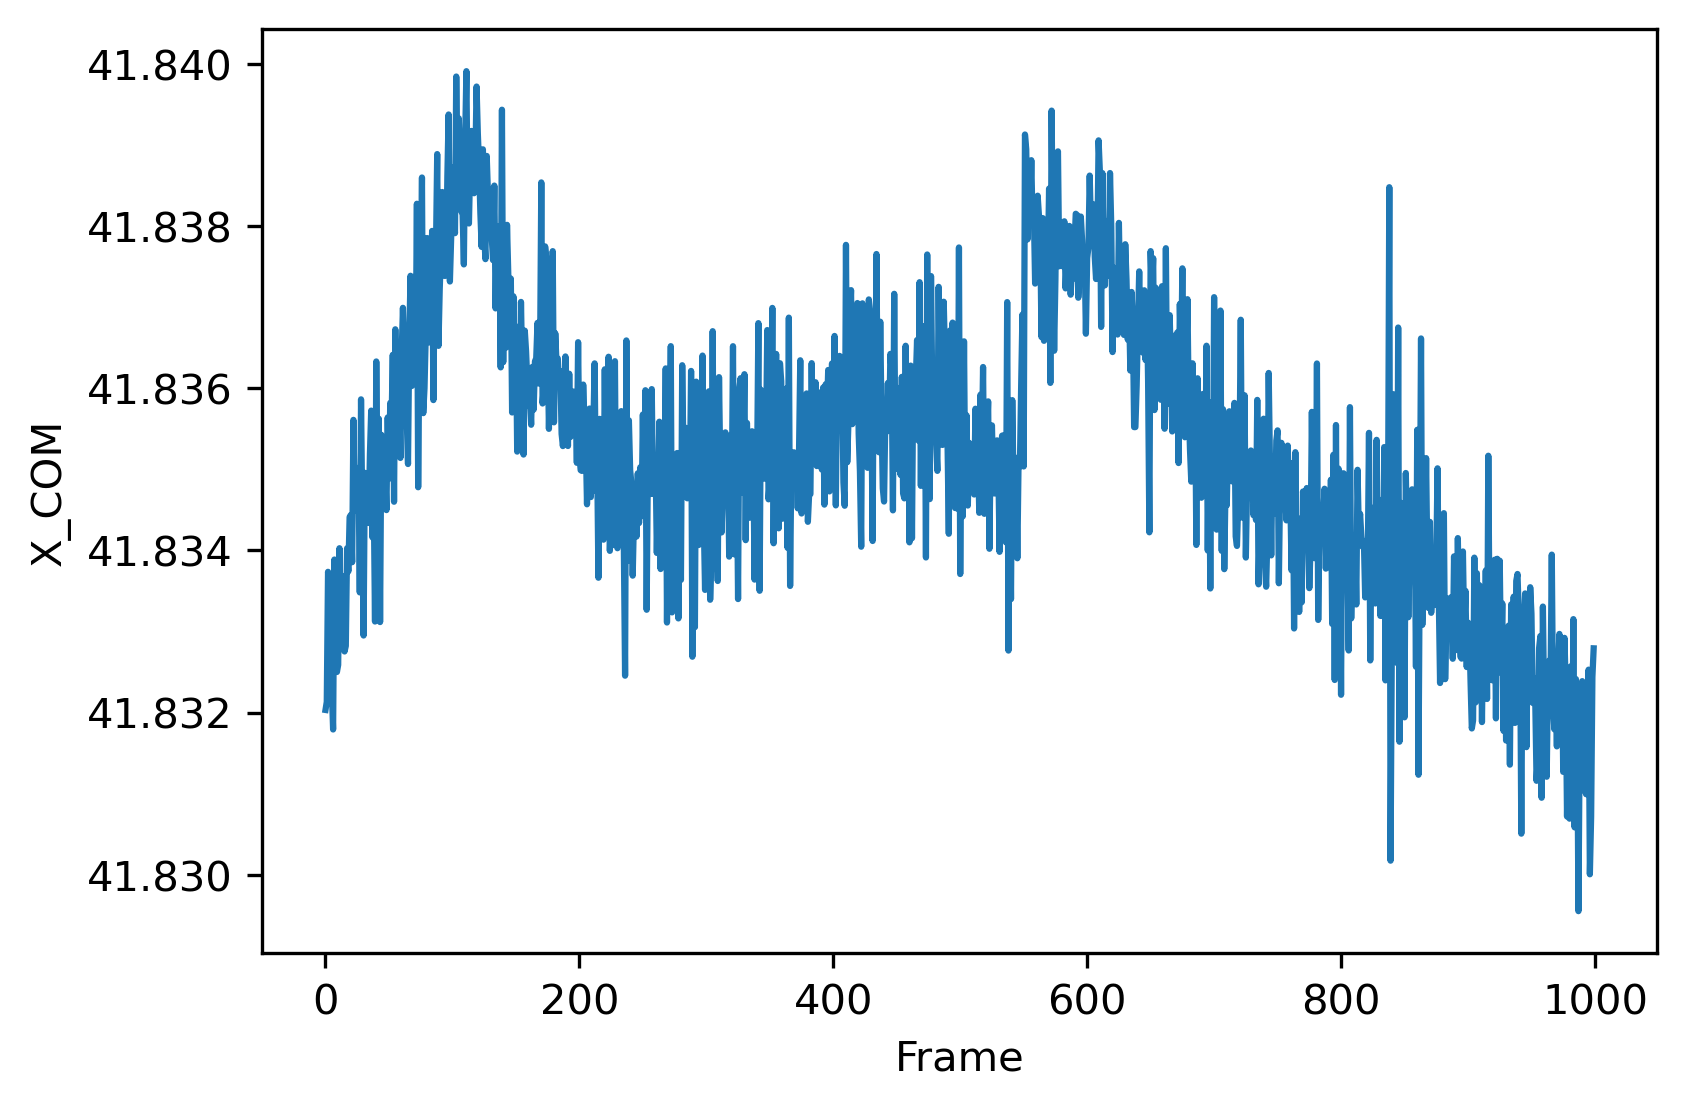

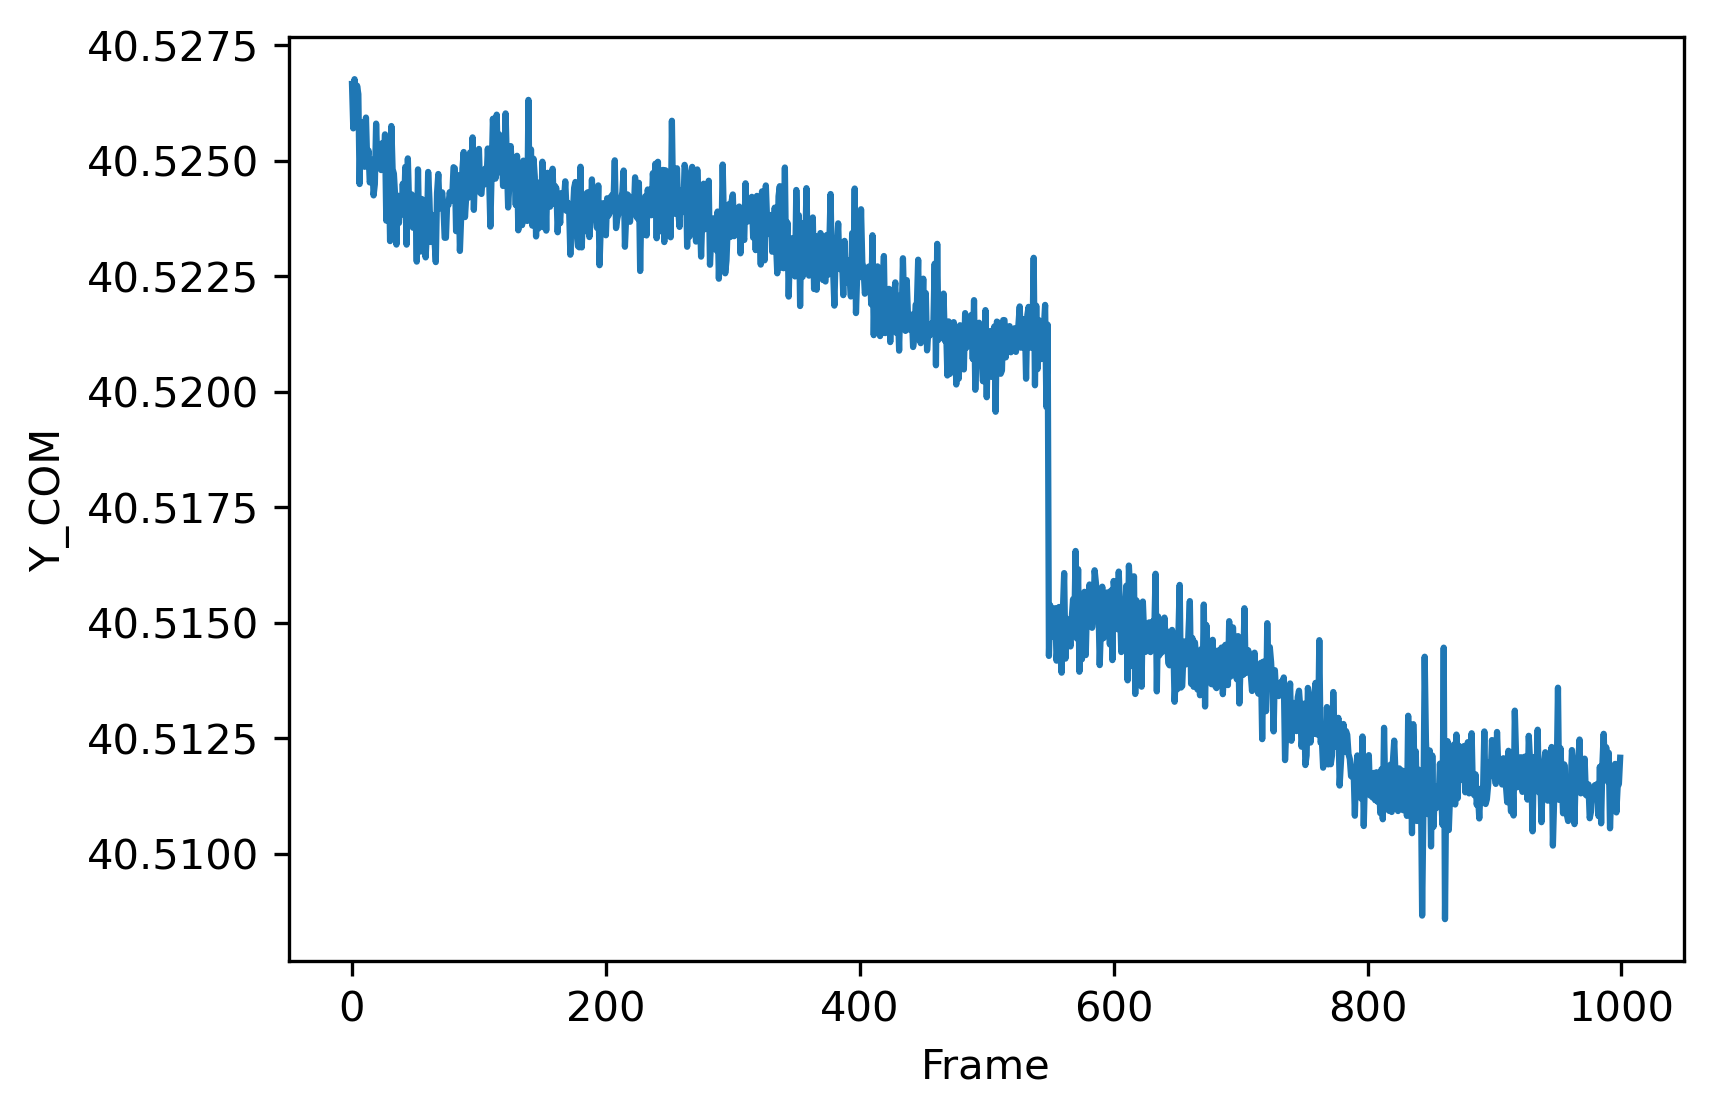

In [1006]:
plt.figure(figsize=(6,4),dpi=300)
plt.plot(Xcom)
plt.xlabel('Frame')
plt.ylabel('X_COM')
plt.savefig(fname+'Xcom.png')
plt.figure(figsize=(6,4),dpi=300)
plt.plot(Ycom)

plt.xlabel('Frame')
plt.ylabel('Y_COM')
plt.savefig(fname+'Ycom.png')
fulltime = np.arange(lastframe)
#np.savetxt(fname+' COM data.txt', np.transpose([fulltime,Xcom,Ycom]),delimiter='\t')

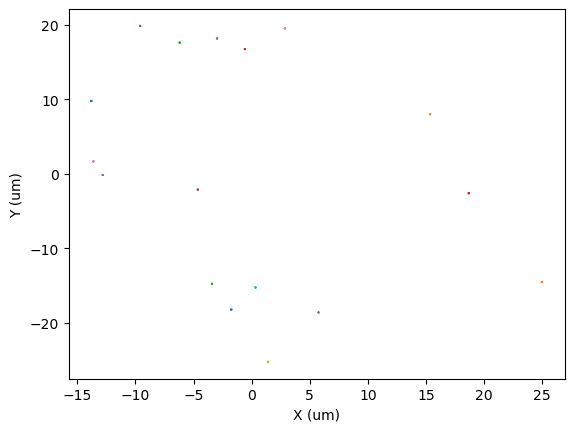

In [1007]:
msds = []
xpos=[]
ypos=[]
i=[]
msdsizes=[]

first_values=[]
last_values=[]
for l in range(int(len(pos))):
    #ind=pos[str(l)]['indx'][0:int(lastframe)]
    start=int(pos[str(l)]['trackData'][0,0])
    xpos=pos[str(l)]['trackData'][0:minframe,1]*pixel_conversion-Xcom[start:start+minframe]
    ypos=pos[str(l)]['trackData'][0:minframe,2]*pixel_conversion-Ycom[start:start+minframe]

    #a,b=np.polyfit(ind,xpos,1)
    #error = a*ind+b
    #xpos = xpos-error 
    #a,b=np.polyfit(ind,ypos,1)
    #error = a*ind+b
    #ypos = ypos-error 
    plt.plot(xpos,ypos)
    nData = len(xpos)
    numberOfdeltaT = int(nData/2)
    msd = np.zeros((numberOfdeltaT,2))
    
    k=0
    for dt in range(numberOfdeltaT+1):
        if dt==0:
            continue
        deltax = xpos[1+dt:len(xpos)-1]-xpos[1:len(xpos)-1-dt]
        deltay = ypos[1+dt:len(ypos)-1]-ypos[1:len(ypos)-1-dt]

        sD = deltax**2+deltay**2
        msd[k,0]  =frametime*dt
        msd[k,1]  =np.mean(sD)
#        msd[k,2]  =np.std(sD)
#        msd[k,3]  =len(sD)
        k=k+1
#    msds.append({"time":msd[:,0], "MSD":msd[:,1],"DMSD":msd[:,2], "MSDsize":len(msd)})
    msds.append({"time":msd[:,0], "MSD":msd[:,1]})
    msdsizes.append(len(msd))
    first_values.append(msd[0,1])
    last_values.append(msd[-1,1])
   
    xpos=[]
    ypos=[]
    i=[]

    plt.xlabel('X (um)')
    plt.ylabel('Y (um)')
    plt.savefig(fname+'tracks.png')

In [1008]:
(xpos[1+dt:len(xpos)-1]), (xpos[1:len(xpos)-1-dt])

([], [])

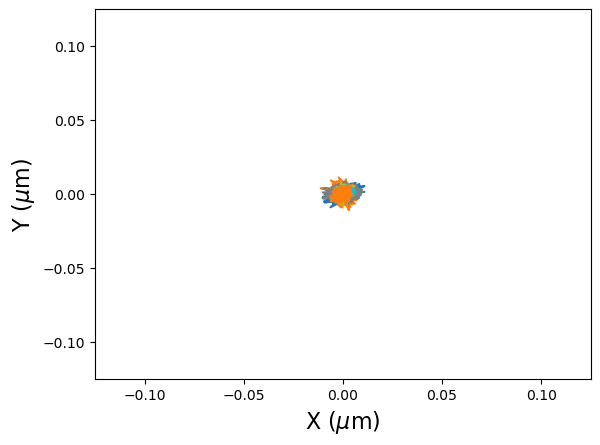

In [1009]:
for j in range(int(len(pos))-1):
    if j not in (1,2,3,9):
        start=int(pos[str(j)]['trackData'][0,0])
        xpos=pos[str(j)]['trackData'][0:minframe,1]*pixel_conversion-Xcom[start:start+minframe]
        ypos=pos[str(j)]['trackData'][0:minframe,2]*pixel_conversion-Ycom[start:start+minframe]
        xpos=xpos-np.mean(xpos)
        ypos=ypos-np.mean(ypos)
        plt.plot(xpos,ypos)
        plt.xlabel(r'X ($\mu$m)', fontsize=16)
        plt.ylabel(r'Y ($\mu$m)', fontsize=16)
        plt.xlim(-0.125,0.125)
        plt.ylim(-0.125,0.125)
        np.savetxt(fname + '_individual track_' + str(j) + '.txt', np.transpose(np.array([xpos,ypos])))
        plt.savefig(fname + '_individual track_' + str(j) + '.png')
        plt.savefig(fname+'individual track_combined_1.png')
#        plt.clf()
#        plt.cla()
#        plt.close()

In [1010]:
import glob2

filenames = glob2.glob('*_individual track_*.txt')  # list of all .txt files in the directory
with open('combined_trajectory_data.txt', 'w') as f:
    for file in filenames:
        with open(file) as infile:
            f.write(infile.read())

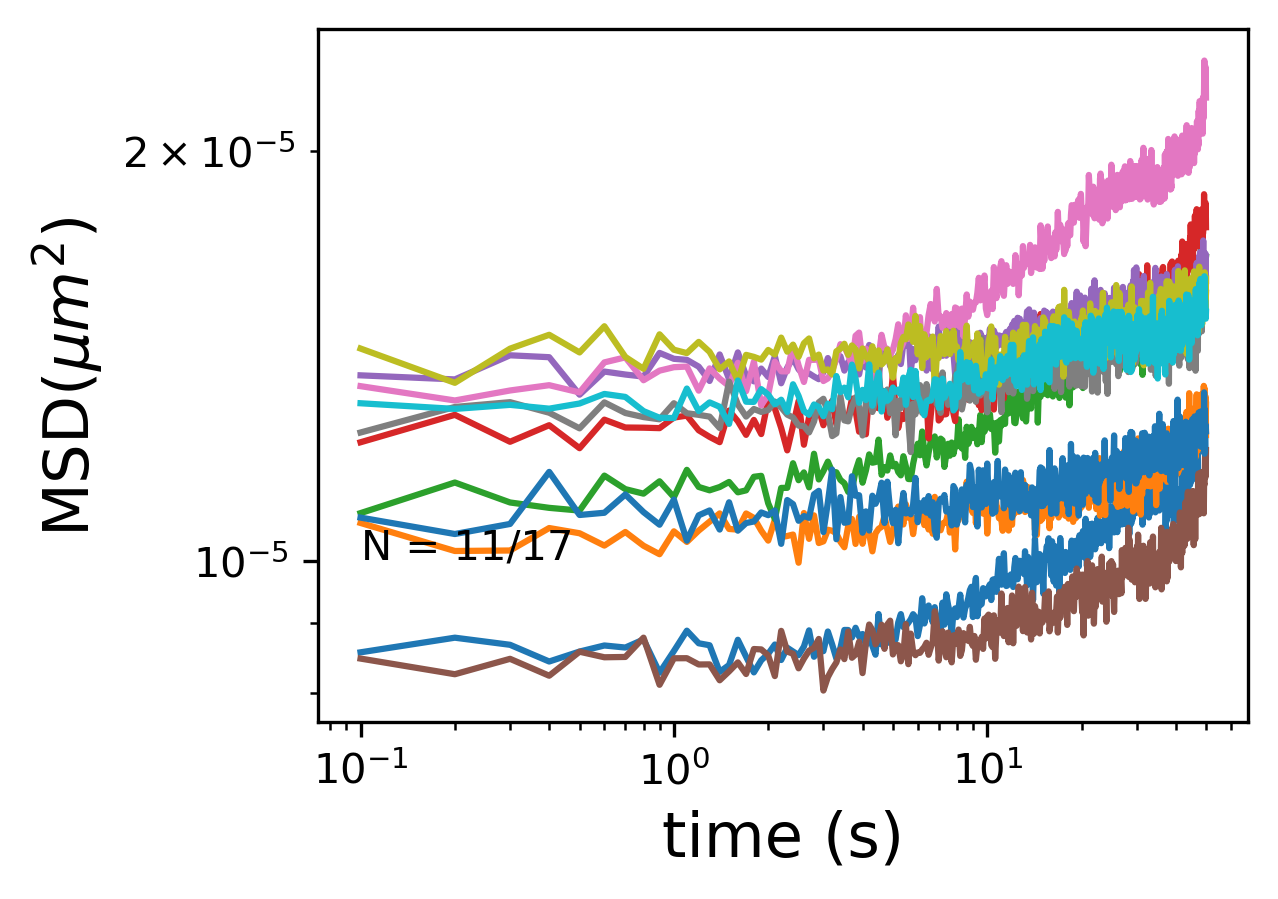

In [1011]:
lower_bound,upper_bound,lower_bound_l,upper_bound_l = get_outlier_bounds(first_values,last_values)
lastind=np.min(msdsizes)-1
totmsd =np.zeros((lastind,))
msd_all=np.zeros((lastind,len(msds)))
plt.figure(figsize=(4,3),dpi=300)
plt.xlabel('time (s)',fontsize=15)
plt.ylabel('MSD($\mu m^2$)',fontsize=15)
count=0
for i in range(len(msds)):
    mmd = np.array(msds[i]['MSD'])
    time= msds[i]['time']
    if not lower_bound <np.log(mmd[0]) <upper_bound:
        continue
    if not lower_bound_l<np.log(mmd[-1])<upper_bound_l:
        continue
#    force filter
#    if mmd[0]>1e-2 or mmd[lastind]<1e-9:
        continue
    plt.loglog(time[:lastind],mmd[:lastind])
    totmsd=totmsd+mmd[0:lastind]
    count+=1
msdavg= totmsd/len(msds)
plt.text(min(time),max(msdavg),'N = ' + str(count)+'/'+str(len(msds)))
plt.savefig(fname+'MSDs_all.eps',bbox_inches='tight')
plt.savefig(fname+'MSDs_all.png',bbox_inches='tight')
time=time[0:lastind]
#plt.loglog(time,msdavg,'o')
np.savetxt(fname+'MSD_new.txt',np.transpose([time,msdavg]), delimiter='\t')   # X is an array

[[Model]]
    Model(MSDfitfit)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 48
    # data points      = 499
    # variables        = 3
    chi-square         = 6.8892e-12
    reduced chi-square = 1.3890e-14
    Akaike info crit   = -15918.9207
    Bayesian info crit = -15906.2829
    R-squared          = 0.96086836
[[Variables]]
    D:      3.4406e-08 +/- 3.3084e-09 (9.62%) (init = 0.2)
    alpha:  0.70729169 +/- 0.02211052 (3.13%) (init = 1)
    N:      7.4503e-06 +/- 3.1214e-08 (0.42%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, alpha) = -0.996
    C(D, N)     = -0.944
    C(alpha, N) = 0.913


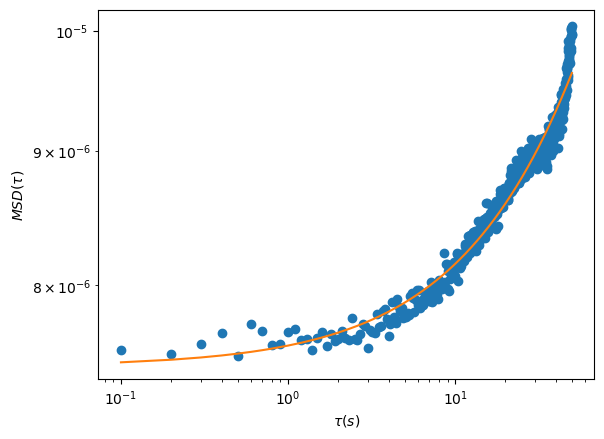

In [1012]:
def MSDfitfit(t, D,alpha,N):
    return 4*D*t**alpha + N

modely = lmfit.Model(MSDfitfit)
params = modely.make_params(D=1.,alpha=1.,N=0)


params['D'].set(value=.2, vary=True)
params['alpha'].set(value=1.0, vary=True)
params['N'].set(value=0.,max=msdavg[0],min=0., vary=True)

start=0
end=500

fitresy = modely.fit(msdavg[start:end], t=time[start:end], params=params ,method='least_squares')
print(fitresy.fit_report())

plt.loglog(time[start:end],msdavg[start:end],'o')
plt.loglog(time[start:end], fitresy.best_fit)
#plt.loglog(time[start:end], fitresy.init_fit)
plt.xlabel(r'$\tau (s)$')
plt.ylabel(r'$MSD(\tau)$')
plt.savefig(fname+'MSDfit.png',bbox_inches='tight')
timenew=np.logspace(-5,10,100000)
#Jnew=modely.eval(fitresy.params,t=timenew)
np.savetxt(fname+'MSDandfit.txt',np.transpose([time[start:end],msdavg[start:end],fitresy.best_fit]))

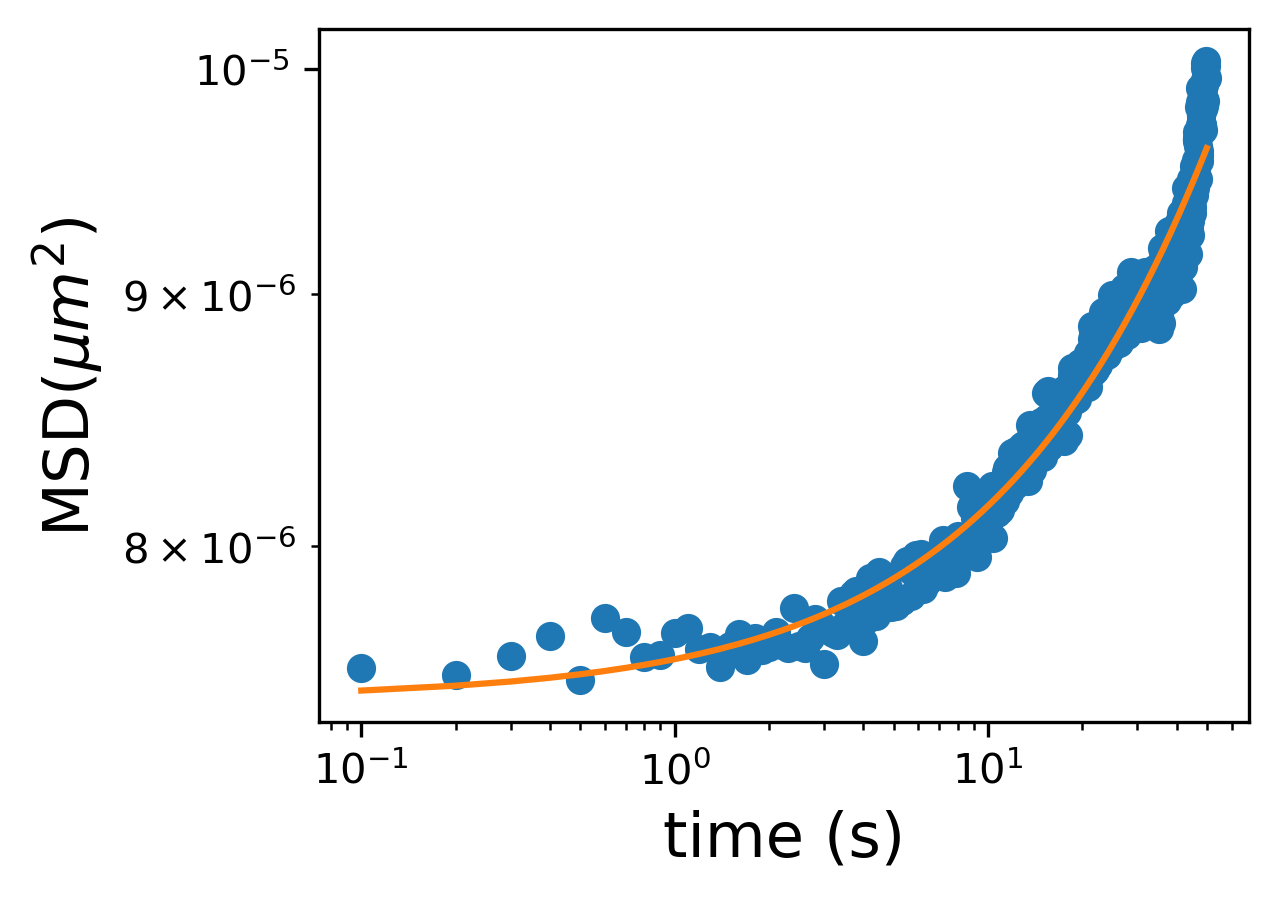

In [1013]:
plt.figure(figsize=(4,3),dpi=300)
plt.loglog(time[start:end],msdavg[start:end],'o')
plt.loglog(time[start:end], fitresy.best_fit)
plt.xlabel('time (s)',fontsize=15)
plt.ylabel('MSD($\mu m^2$)',fontsize=15)
plt.savefig(fname+'MSDs_fit.svg',bbox_inches='tight')

In [1014]:
k=  1.38064852e-23 #boltzmann const
const = 1e18*k/(6*np.pi)
eta = const*(T+273.15)/(R*fitresy.best_values['D'])
eta # in Pa.s

63258.94661727576

In [1015]:
import csv
f = open(fname+'_fitting_report.txt','w')
f.write(fitresy.fit_report())
f.close()
out=open('fitting_params.txt','a')
line_exp = str(fitresy.best_values['D'])+'\t'+str(fitresy.best_values['alpha'])+'\t'+str(fitresy.best_values['N'])
out.write(str(line_exp)+'\n')
out.close()
out=open('viscosity.txt','a')
out.write(str(T)+'\t'+str(eta)+'\n')
out.close()

In [492]:
r"F:\primovert_blackfly\90 percent glycerol 100x" + r'\viscosity.txt'

'F:\\primovert_blackfly\\90 percent glycerol 100x\\viscosity.txt'

In [21]:
os.getcwd()+'\\..\\..\\'

'D:\\Anurag_data\\G3BP1_maturation\\G3BP1_maturation_VPT\\02092023\\50uM 10% Ficoll 150mM NaCl 50mM HEPES pH 7.5\\3.30hr_1\\..\\..\\'

In [22]:
M=np.loadtxt(r'F:\Activation Energy Data\RG5-10S30L 250 mM NaCl 10 minutes wait\viscosity_all.txt')

OSError: F:\Activation Energy Data\RG5-10S30L 250 mM NaCl 10 minutes wait\viscosity_all.txt not found.

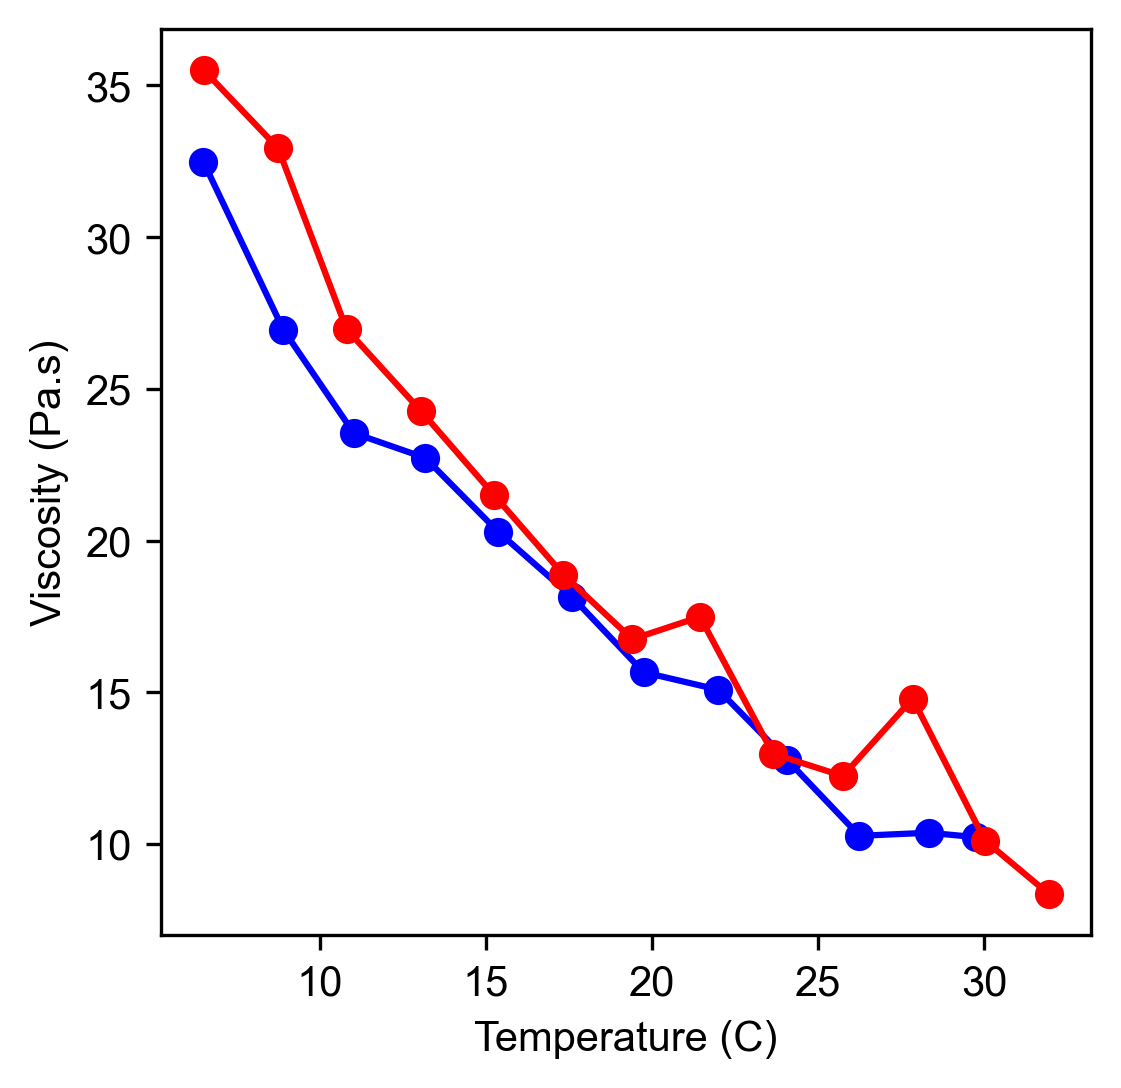

In [577]:
plt.figure(figsize=(4,4),dpi=300)
plt.rcParams['font.sans-serif'] = "Arial"
plt.plot(M[:12,0],M[:12,1],'bo-')
plt.plot(M[12:,0],M[12:,1],'ro-')
plt.xlabel("Temperature (C)")
plt.ylabel("Viscosity (Pa.s)")
plt.savefig(r'F:\Activation Energy Data\RG5-10S30L 250 mM NaCl\eta.png',bbox_inches="tight")
plt.savefig(r'F:\Activation Energy Data\RG5-10S30L 250 mM NaCl\eta.svg',bbox_inches="tight")

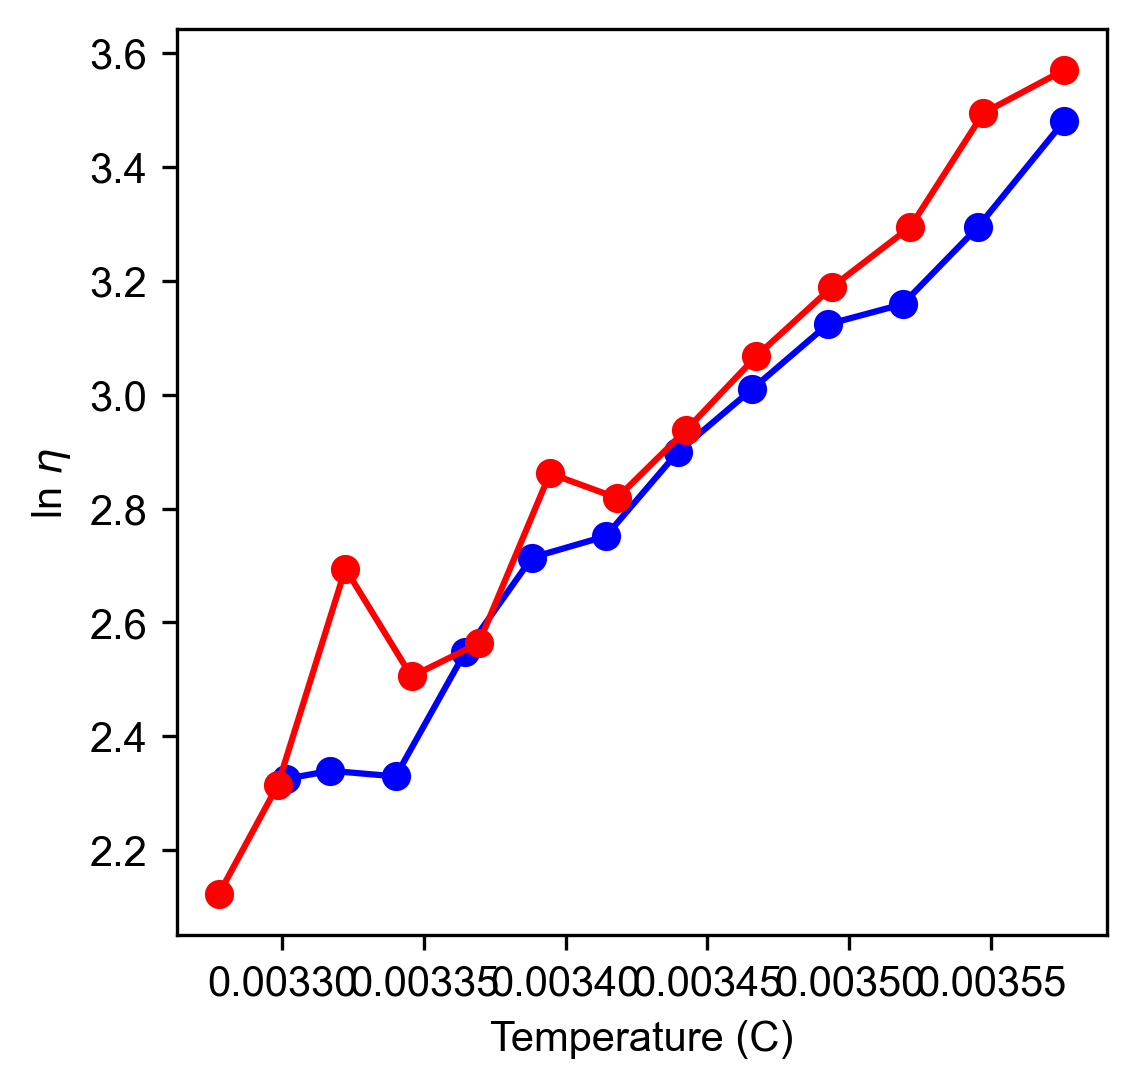

In [578]:
inv_t = 1/(M[:,0]+273.15)
lneta = np.log(M[:,1])

plt.figure(figsize=(4,4),dpi=300)
plt.rcParams['font.sans-serif'] = "Arial"
plt.plot(inv_t[:12],lneta[:12],'bo-')
plt.plot(inv_t[12:],lneta[12:],'ro-')
plt.xlabel("Temperature (C)")
plt.ylabel("ln $\eta$")
plt.savefig(r'F:\Activation Energy Data\RG5-10S30L 250 mM NaCl\ln eta.png',bbox_inches="tight")
plt.savefig(r'F:\Activation Energy Data\RG5-10S30L 250 mM NaCl\ln eta.svg',bbox_inches="tight")